In [17]:
import torch
import math

from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed, AutoModel, AutoConfig, AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader

import json
from datasets import load_dataset, load_from_disk
import os
from tqdm import tqdm

import pickle
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature
from modular_transformers.models.gpt2.configuration_gpt2 import GPT2Config

from modular_transformers.models import components

# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix


#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#set tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

dir_path = "/om2/user/jackking/modular_transformers/scripts/new_project"

judge_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", trust_remote_code=True).to(device)
judge_model.eval()

batch_size = 200

def random_perturbation(size):
    def hook(input, hook):
        noise = torch.randn_like(input)
        input_norm = torch.norm(input, dim=-1, keepdim=True)
        noise = noise / torch.norm(noise, dim=-1, keepdim=True) * input_norm * size
        input = input + noise
        return input
    return hook

perturbation_functions_dict = {
    "random": random_perturbation,
}

def get_hooked_model(model_name):
    if model_name == "gpt2":
        model = HookedTransformer.from_pretrained(model_name, device=device)
    else:
        path = f'/om2/user/jackking/MyData/mt/miniberta_100M/{model_name}/checkpoint_final'
        model = AutoModel.from_pretrained(path)
        state_dict = model.state_dict()
        model = HookedTransformer.from_pretrained("gpt2", device=device)
        model.load_state_dict(state_dict, strict=False)

    model.to(device)
    model.eval()
    return model

def get_model(model_name):
    if model_name == "gpt2":
        model = GPT2LMHeadModel.from_pretrained(model_name)
    else:
        path = f'/om2/user/jackking/MyData/mt/miniberta_100M/{model_name}/checkpoint_final'
        model = AutoModelForCausalLM.from_pretrained(path)
    model.to(device)
    model.eval()
    return model

def get_data(data_type):
    if data_type == "ud":
        data_dir = "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
        with open(data_dir, 'rb') as f:
            data = pickle.load(f)
        tokenizer.pad_token = tokenizer.eos_token
        data = tokenizer.batch_encode_plus(data, add_special_tokens=True, padding='longest', return_tensors="pt")["input_ids"]  
        data = data[:, :10].to(device)
        data = data[:5000]
    return data

def record_by_word_stats(model, data):
    surprisals = np.zeros((len(data), len(data[0])))
    entropies = np.zeros((len(data), len(data[0])))

    for batch_idx in range(0, 5000, batch_size):
        input = data[batch_idx:batch_idx+batch_size]
        #batch_size x seq_len x vocab_size
        logits = model(input)
        base_probs = F.softmax(logits, dim=-1).cpu().detach().numpy()
        #batch_size x seq_len
        output_tokens = np.argmax(logits.cpu().detach().numpy(), axis=-1)

        judge_logits = judge_model(input)[0]
        judge_log_probs = F.log_softmax(judge_logits, dim=-1).cpu().detach().numpy()

        for i in range(input.shape[0]):
            #for each position in the sentence, find the surprisal of the output token of the base model evaluated by the judge model
            token_log_probs = -judge_log_probs[i, np.arange(len(output_tokens[i])), output_tokens[i]]
            surprisals[i] = token_log_probs

            #for each position in the sentence, find the entropy of the output distribution
            entropies[i] = -np.sum(base_probs[i] * np.log(base_probs[i]), axis=-1)
    
    return entropies, surprisals

def continued_gen(model, data, length=10, start_size=3):
    #generate new sentences by adding new token to the end of the sentence
    final_data = torch.zeros((len(data), length), dtype=torch.int64).to(device)

    batch_indxs = torch.arange(0, len(data), batch_size)
    for i in range(len(batch_indxs) - 1):
        batch = data[batch_indxs[i]:batch_indxs[i+1]]

        for _ in range(length - start_size):
            logits = model(batch)
            new_tokens = logits.argmax(dim=-1)[:, -1]
            batch = torch.cat([batch, new_tokens.unsqueeze(1)], dim=1)
            torch.cuda.empty_cache()

        final_data[batch_indxs[i]:batch_indxs[i+1], :] = batch.type(torch.int64)
    
    return final_data

def record_generation_surprisal(model, data):
    start_size = 3
    data = data[:, :start_size]
    length = 10
    surprisals = np.zeros((len(data), length-1))
    gen_data = continued_gen(model, data, length=length, start_size=start_size)

    for batch_idx in range(0, 5000, batch_size):
        input = gen_data[batch_idx:batch_idx+batch_size]
        judge_logits = judge_model(input)[0]
        judge_log_probs = F.log_softmax(judge_logits, dim=-1).cpu().detach().numpy()

        for i in range(input.shape[0]):
            token_log_probs = -judge_log_probs[i, np.arange(len(input[i])-1), input[i, 1:].cpu().numpy()]
            surprisals[i] = token_log_probs

    return surprisals


def add_hooks(model, perturbation_function, perturbation_location, size):
    if perturbation_function == "none":
        return
    perturbation_function = perturbation_functions_dict[perturbation_function]
    model.add_perma_hook(name=perturbation_location, hook=perturbation_function(size))


def run(surprisal_dict, model_names, perturbation_functions, sizes, layers):
    for model_name in model_names:
        if not model_name in surprisal_dict: surprisal_dict[model_name] = {}
        print(f"Running {model_name}")
        model = get_hooked_model(model_name)
        for perturbation_function in perturbation_functions:
            if not perturbation_function in surprisal_dict[model_name]: surprisal_dict[model_name][perturbation_function] = {}
            for layer in layers:
                if not layer in surprisal_dict[model_name][perturbation_function]: surprisal_dict[model_name][perturbation_function][layer] = {}
                print(f"       Running {perturbation_function} on layer {layer}")
                perturbation_location = f"blocks.{layer}.hook_resid_post"
                for size in sizes:
                    if size in surprisal_dict[model_name][perturbation_function][layer]:
                        # continue
                        pass
                    else:
                        surprisal_dict[model_name][perturbation_function][layer][size] = {}

                    add_hooks(model, perturbation_function, perturbation_location, size)
                    entropy, word_surprisal = record_by_word_stats(model, data)
                    surprisal_dict[model_name][perturbation_function][layer][size]["entropy"] = entropy
                    surprisal_dict[model_name][perturbation_function][layer][size]["word_surprisal"] = word_surprisal
                    generation_surprisal = record_generation_surprisal(model, data)
                    surprisal_dict[model_name][perturbation_function][layer][size]["generation_surprisal"] = generation_surprisal

                    #save
                    with open(f"{dir_path}/surprisal_dict.pkl", "wb") as f:
                        pickle.dump(surprisal_dict, f)
                    model.reset_hooks()

def run_regular(surprisal_dict, model_names, data):
    for model_name in model_names:
        if not model_name in surprisal_dict: surprisal_dict[model_name] = {}
        print(f"Running {model_name}")
        model = get_hooked_model(model_name)
        if not "regular" in surprisal_dict[model_name]: surprisal_dict[model_name]["regular"] = {}
        entropy, word_surprisal = record_by_word_stats(model, data)
        surprisal_dict[model_name]["regular"]["entropy"] = entropy
        surprisal_dict[model_name]["regular"]["word_surprisal"] = word_surprisal
        generation_surprisal = record_generation_surprisal(model, data)
        surprisal_dict[model_name]["regular"]["generation_surprisal"] = generation_surprisal

        #save
        with open(f"{dir_path}/surprisal_dict.pkl", "wb") as f:
            pickle.dump(surprisal_dict, f)

def record_curvature(curvature_dict, model_names, data):
    for model_name in model_names:
        # if model_name in curvature_dict: continue
        model = get_model(model_name)
        activations = compute_model_activations(model, data, device)
        curvature = compute_model_curvature(activations)
        curvature_dict[model_name] = curvature
        with open(f"{dir_path}/curvature_dict.pkl", "wb") as f:
            pickle.dump(curvature_dict, f)

def perturb_inputs(input_ids, perturbation_type):
    perturbation_amount = math.ceil(len(input_ids) * 0.1)
    if perturbation_type == "swap":
        for i in range(perturbation_amount):
            idx1, idx2 = np.random.choice(len(input_ids), 2)
            input_ids[idx1], input_ids[idx2] = input_ids[idx2], input_ids[idx1]
        return input_ids
    elif perturbation_type == "remove":
        for i in range(perturbation_amount):
            idx = np.random.choice(len(input_ids))
            input_ids[idx] = tokenizer.pad_token_id
        return input_ids
    elif perturbation_type == "replace":
        for i in range(perturbation_amount):
            idx = np.random.choice(len(input_ids))
            input_ids[idx] = np.random.choice(len(tokenizer))
        return input_ids
    else:
        raise ValueError(f"perturbation_type {perturbation_type} not recognized")

def get_qa_qp(dataset, perturbation_type):
    queries = dataset["best_answer"]
    if perturbation_type == "none" or "activation" in perturbation_type:
        prefixes = dataset["question"]
    else:
        prefixes = [tokenizer.encode(question) for question in dataset["question"]]
        prefixes = [tokenizer.decode(perturb_inputs(prefix, perturbation_type)) for prefix in prefixes]
    
    return queries, prefixes

def record_conditional_surprisal(model, queries, prefixes):
    surprisals = []
    for i in range(len(queries)):
        query = tokenizer.encode(queries[i])
        prefix = tokenizer.encode(prefixes[i])
        input = torch.tensor([prefix + query]).to(device)
        logits = model(input)[0][0]
        neg_log_probs = -F.log_softmax(logits, dim=-1).cpu().detach().numpy()
        neg_log_probs = neg_log_probs[len(prefix):]
        neg_log_probs = neg_log_probs[np.arange(len(query)-1), query[1:]].mean()
        surprisals.append(neg_log_probs)
    return np.array(surprisals)

def run_input_perturbation_surprisals(model_names, prefixes, queries, perturbation_type, surprisal_type):
    if os.path.exists(f"{dir_path}/input_pert_surprisal_dict.pkl"):
        surprisal_dict = pickle.load(open(f"{dir_path}/input_pert_surprisal_dict.pkl", "rb"))
    else:
        surprisal_dict = {}

    for model_name in model_names:
        if model_name not in surprisal_dict: surprisal_dict[model_name] = {}
        model = get_model(model_name)
        if not perturbation_type in surprisal_dict[model_name]: surprisal_dict[model_name][perturbation_type] = {}
        if not surprisal_type in surprisal_dict[model_name][perturbation_type]: surprisal_dict[model_name][perturbation_type][surprisal_type] = {}
        print(f"Running {model_name} on {perturbation_type} {surprisal_type}")
        surprisals = record_conditional_surprisal(model, queries, prefixes)
        surprisal_dict[model_name][perturbation_type][surprisal_type] = surprisals
        with open(f"{dir_path}/input_pert_surprisal_dict.pkl", "wb") as f:
            pickle.dump(surprisal_dict, f)

if __name__ == "__main__":


    data_type = "ud"
    data = get_data(data_type)

    # model_names = ["epochs10-768x12", "delay3-warmup10-lr0.0003-0.001-layer7-curvature-epochs10-768x12",
    #                 "warmup10-lr0.0003-0.001-layer7-l2_curvature-epochs10-768x12", "warmup10-lr0.0003-0.001-layer7-curvature-epochs10-768x12",
    #                 "warmup10-lr0.0003-0.001-layer7-sparsity-epochs10-768x12"]
    
    model_names = ["warmup3-lr0.0003-0.0005-layer7-sparsity-epochs10-768x12", "delay3-warmup10-lr0.0003-0.1-layer7-curvature-epochs10-768x12", "delay3-warmup10-lr0.0003-0.001-layer7-sparsity-epochs15-768x12", 
                   "delay3-warmup10-lr0.0003-0.01-layer7-sparsity-epochs10-768x12", "delay3-warmup10-lr0.0003-0.001-layer7-sparsity-epochs10-768x12", "delay3-warmup10-lr0.0003-0.001-layer7-curvature-epochs10-768x12", 
                   "warmup10-lr0.0003-0.001-layer7-l2_curvature-epochs10-768x12", "epochs10-768x12", "warmup10-lr0.0003-0.001-layer7-curvature-epochs10-768x12",
                   "warmup10-lr0.0003-0.001-layer7-sparsity-epochs10-768x12", "warmup10-lr0.0003-1-layer7-l2_curvature-epochs10-768x12", "warmup10-lr0.0003-0.01-layer7-sparsity-epochs10-768x12", "warmup2-lr0.0003-0.0001-layer7-sparsity-epochs10-768x12",
                   "7-attn-0.8-7-embd-0.8-epochs10-768x12", "7-embd-0.8-epochs10-768x12", "768x12"]
    
    model_names = ["warmup2-lr0.0003-0.0001-layer7-sparsity-epochs10-768x12"]
    
    # if os.path.exists(f"{dir_path}/curvature_dict.pkl"):
    #     curvature_dict = pickle.load(open(f"{dir_path}/curvature_dict.pkl", "rb"))
    # else:
    #     curvature_dict = {}
    # record_curvature(curvature_dict, model_names, data)

    # perturbation_functions = ["random"]
    # sizes = [0.1, 0.25, 1, 0.5, 2]
    # layers = [1, 3, 5, 7, 9]
    if os.path.exists(f"{dir_path}/surprisal_dict.pkl"):
        surprisal_dict = pickle.load(open(f"{dir_path}/surprisal_dict.pkl", "rb"))
    else:
        surprisal_dict = {}
    # run(surprisal_dict, model_names, perturbation_functions, sizes, layers)

    run_regular(surprisal_dict, model_names, data)

    # #types
    #     #entropy: entropy of output
    #     #word_surprisal: surprisal from a larger model on output of trained model (word by word)
    #     #generation_surprisal: surprisal from a larger model on output of trained model (autoregressively given short input string)

    # surprisal_type = "question_answering"
    # dataset = load_dataset('truthful_qa', 'generation', split='validation')

    # for perturbation_type in ["none", "swap", "remove", "replace"]:
    #     queries, prefixes = get_qa_qp(dataset, perturbation_type)
    #     run_input_perturbation_surprisals(model_names, prefixes, queries, perturbation_type, surprisal_type)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


Running warmup2-lr0.0003-0.0001-layer7-sparsity-epochs10-768x12
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda


In [2]:
import torch
import math

from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed, AutoModel, AutoConfig, AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import textwrap

import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader

import json
from datasets import load_dataset, load_from_disk
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature
from modular_transformers.models.gpt2.configuration_gpt2 import GPT2Config

dir_path = "/om2/user/jackking/modular_transformers/scripts/new_project"

In [32]:
def visualize_all_sizes_surprisal_differences(model_names, surprisal_dict, perturbation_function, layer, sizes, suprisal_measure):
    
    surprisal_dict = pickle.load(open(f"{dir_path}/surprisal_dict.pkl", "rb"))

    plt.figure(figsize=(15, 5))

    cmap = {0.1: 'r', 0.25: 'b', 0.5: 'g', 1: 'y', 2: 'c', 5: 'm'}

    for i, model_name in enumerate(model_names):
        regular = surprisal_dict[model_name]["regular"][suprisal_measure]
        regular = regular[:, 3:].mean(axis=1)
        conf_inv = np.nanstd(regular) * 1.96 / np.sqrt(regular.shape[0])
        plt.bar(textwrap.fill(model_name, width=12), np.nanmean(regular), yerr=conf_inv, color='b')
    
        for size in sizes:
            changed = surprisal_dict[model_name][perturbation_function][layer][size][suprisal_measure]
            changed = changed[:, 3:].mean(axis=1)
            conf_inv = np.nanstd(changed) * 1.96 / np.sqrt(changed.shape[0])
            plt.bar(textwrap.fill(model_name + str(size), width=8), np.nanmean(changed), yerr=conf_inv, color=cmap[size])
        
        plt.bar(textwrap.fill(model_name + str(100), width=8), 0)

    ax = plt.gca()
    tick_labels = ax.get_xticklabels()
    for i in range(len(tick_labels)):
        if not i % (len(sizes)+2) == 0:
            tick_labels[i].set_text('')
    ax.set_xticklabels(tick_labels)

    plt.title(f"Surprisals of Models with Layer {layer} Perturbation")
    plt.xlabel("Position")
    plt.ylabel("Surprisal")

    plt.show()

def plot_curvature(model_names, curvature_dict):
    plt.figure(figsize=(10, 5))
    for model_name in model_names:
        curvature = curvature_dict[model_name]
        curve = curvature["curve"]
        plt.plot(np.mean(curve, axis=-1) * 180 / np.pi, label=model_name)
    plt.title("curvatures")
    plt.legend()
    plt.show()

def plot_surprisal(model_names, surprisal_dict, perturbation_function, layer, size, surprisal_measure):
    plt.figure(figsize=(10, 5))
    plt.title(f"{surprisal_measure} of Models with Layer {layer} Perturbation")
    for model_name in model_names:
        measure = surprisal_dict[model_name][perturbation_function][layer][size][surprisal_measure]
        measure = measure[:, 3:].mean(axis=1)
        conf_inv = np.nanstd(measure) * 1.96 / np.sqrt(measure.shape[0])
        plt.bar(textwrap.fill(model_name, width=12), np.nanmean(measure), yerr=conf_inv, color='b')
    plt.show()

def plot_input_perturbations(model_names, surprisal_dict, perturbation_type, surprisal_type):
    plt.figure(figsize=(10, 5))
    plt.title(f"{surprisal_type} of Models with {perturbation_type} Perturbation")
    for model_name in model_names:
        base_measure = surprisal_dict[model_name]["none"][surprisal_type]
        conf_inv = np.nanstd(base_measure) * 1.96 / np.sqrt(base_measure.shape[0])
        plt.bar(textwrap.fill(model_name, width=12), np.nanmean(base_measure), yerr=conf_inv, color='b')

        measure = surprisal_dict[model_name][perturbation_type][surprisal_type]
        conf_inv = np.nanstd(measure) * 1.96 / np.sqrt(measure.shape[0])
        plt.bar(textwrap.fill(model_name + "pert", width=12), np.nanmean(measure), yerr=conf_inv, color='r')

    plt.show()

In [18]:
surprisal_dict = pickle.load(open(f"{dir_path}/surprisal_dict.pkl", "rb"))
curvature_dict = pickle.load(open(f"{dir_path}/curvature_dict.pkl", "rb"))

# model_names = ["warmup3-lr0.0003-0.0005-layer7-sparsity-epochs10-768x12", "delay3-warmup10-lr0.0003-0.1-layer7-curvature-epochs10-768x12", "delay3-warmup10-lr0.0003-0.001-layer7-sparsity-epochs15-768x12", 
#                    "delay3-warmup10-lr0.0003-0.01-layer7-sparsity-epochs10-768x12", "delay3-warmup10-lr0.0003-0.001-layer7-sparsity-epochs10-768x12", "delay3-warmup10-lr0.0003-0.001-layer7-curvature-epochs10-768x12", 
#                    "warmup10-lr0.0003-0.001-layer7-l2_curvature-epochs10-768x12", "epochs10-768x12", "warmup10-lr0.0003-0.001-layer7-curvature-epochs10-768x12",
#                    "warmup10-lr0.0003-0.001-layer7-sparsity-epochs10-768x12", "warmup10-lr0.0003-1-layer7-l2_curvature-epochs10-768x12", "warmup10-lr0.0003-0.01-layer7-sparsity-epochs10-768x12", "warmup2-lr0.0003-0.0001-layer7-sparsity-epochs10-768x12",
#                    "7-attn-0.8-7-embd-0.8-epochs10-768x12", "7-embd-0.8-epochs10-768x12", "768x12"]

# model_names = ["delay3-warmup10-lr0.0003-0.1-layer7-curvature-epochs10-768x12", "delay3-warmup10-lr0.0003-0.001-layer7-sparsity-epochs15-768x12", 
#                     "delay3-warmup10-lr0.0003-0.001-layer7-sparsity-epochs10-768x12", 
#                    "warmup10-lr0.0003-0.001-layer7-l2_curvature-epochs10-768x12", "epochs10-768x12", "warmup10-lr0.0003-0.001-layer7-curvature-epochs10-768x12"]

model_names = ["warmup2-lr0.0003-0.0001-layer7-sparsity-epochs10-768x12", "delay3-warmup10-lr0.0003-0.1-layer7-curvature-epochs10-768x12", "delay3-warmup10-lr0.0003-0.001-layer7-sparsity-epochs10-768x12", "epochs10-768x12"]

# model_names = ["7-embd-0.8-epochs10-768x12", "768x12", "7-attn-0.8-7-embd-0.8-epochs10-768x12"]

In [ ]:
plot_curvature(model_names, curvature_dict)

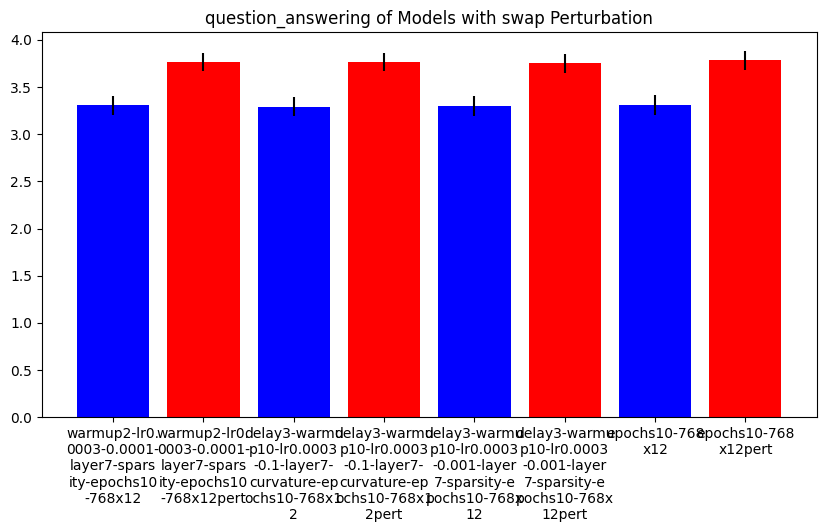

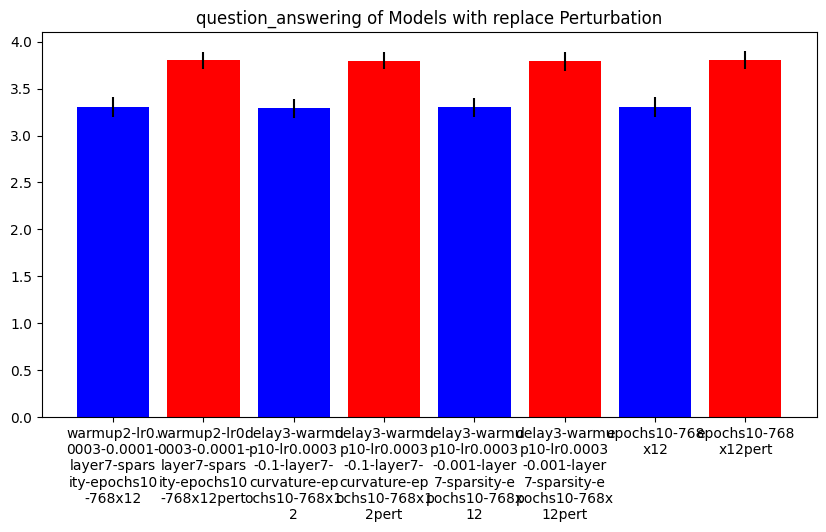

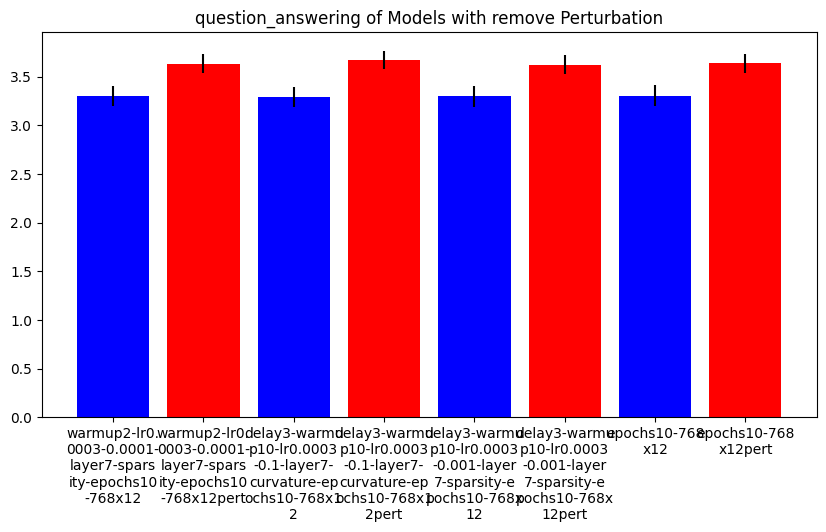

In [25]:
input_surprisal_dict = pickle.load(open(f"{dir_path}/input_pert_surprisal_dict.pkl", "rb"))

plot_input_perturbations(model_names, input_surprisal_dict, "swap", "question_answering")
plot_input_perturbations(model_names, input_surprisal_dict, "replace", "question_answering")
plot_input_perturbations(model_names, input_surprisal_dict, "remove", "question_answering")

/tmp/ipykernel_2956197/2009835341.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


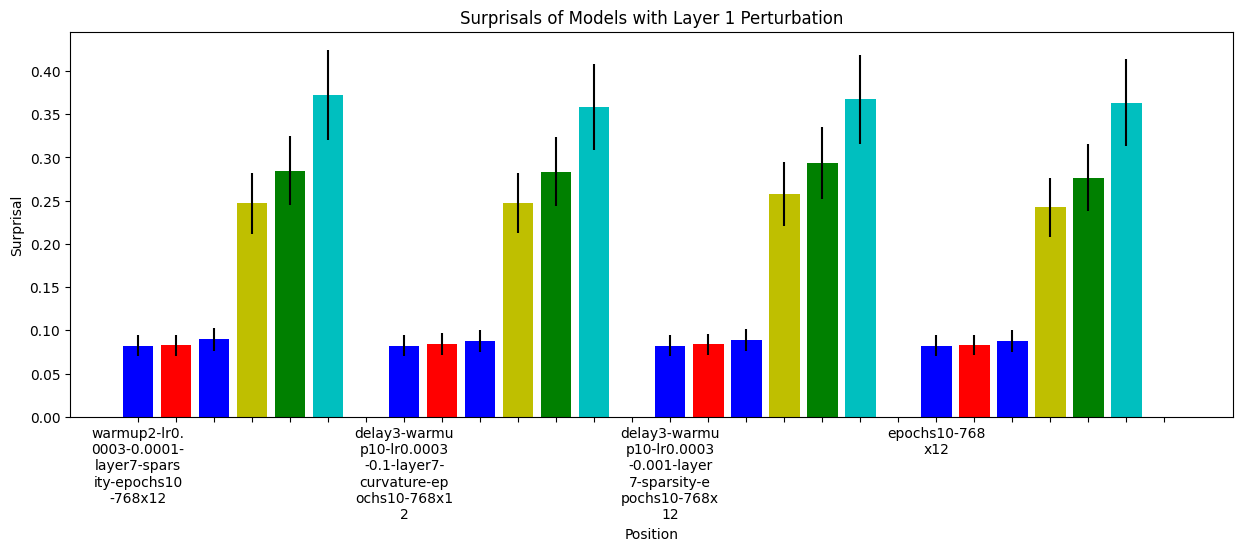

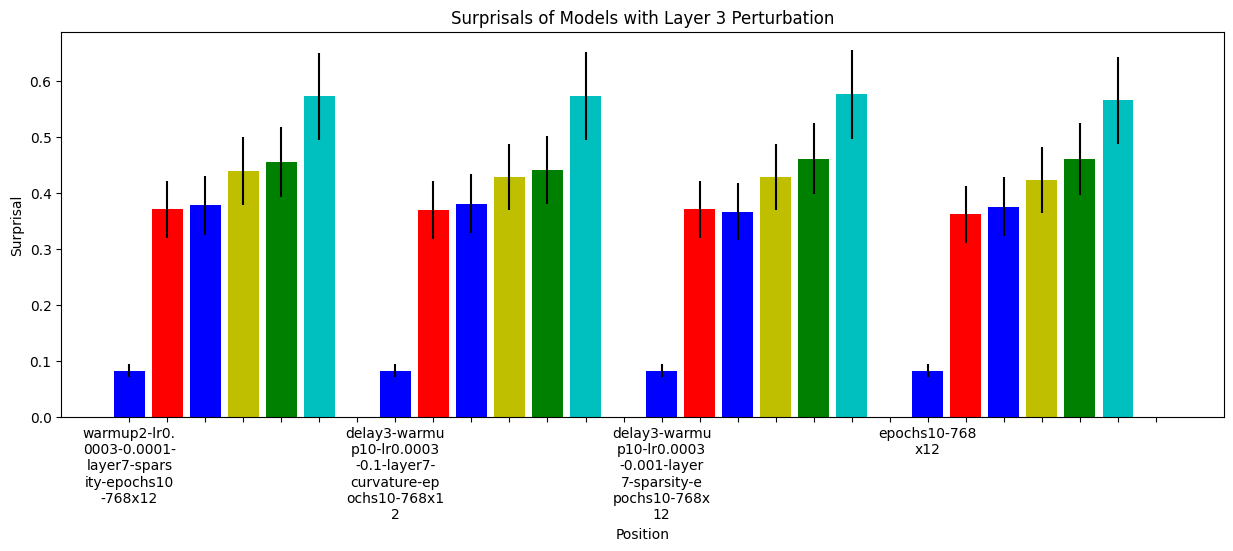

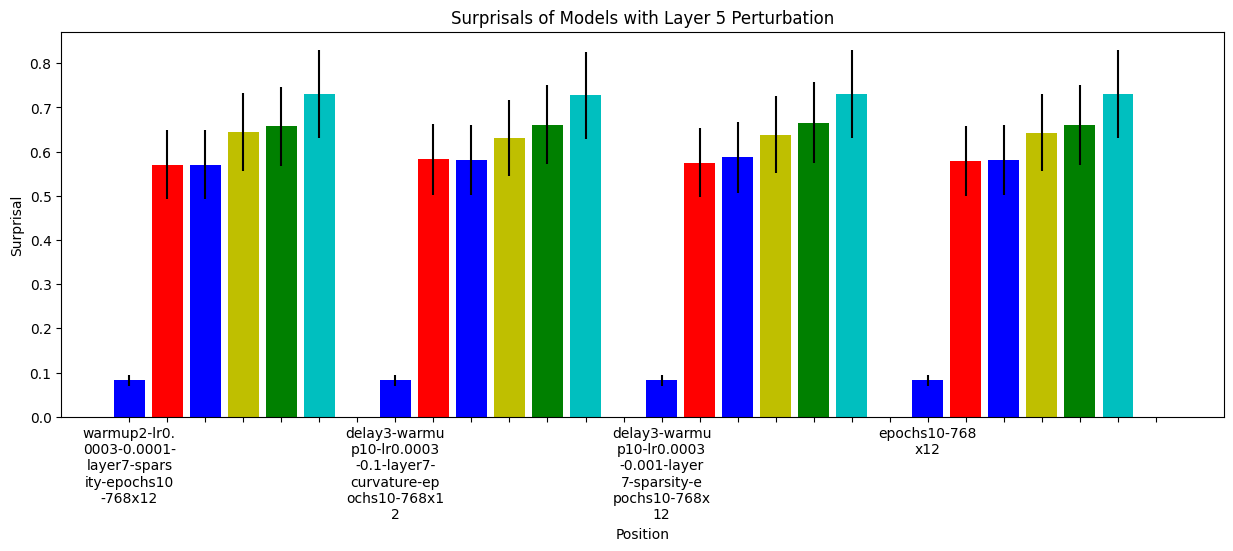

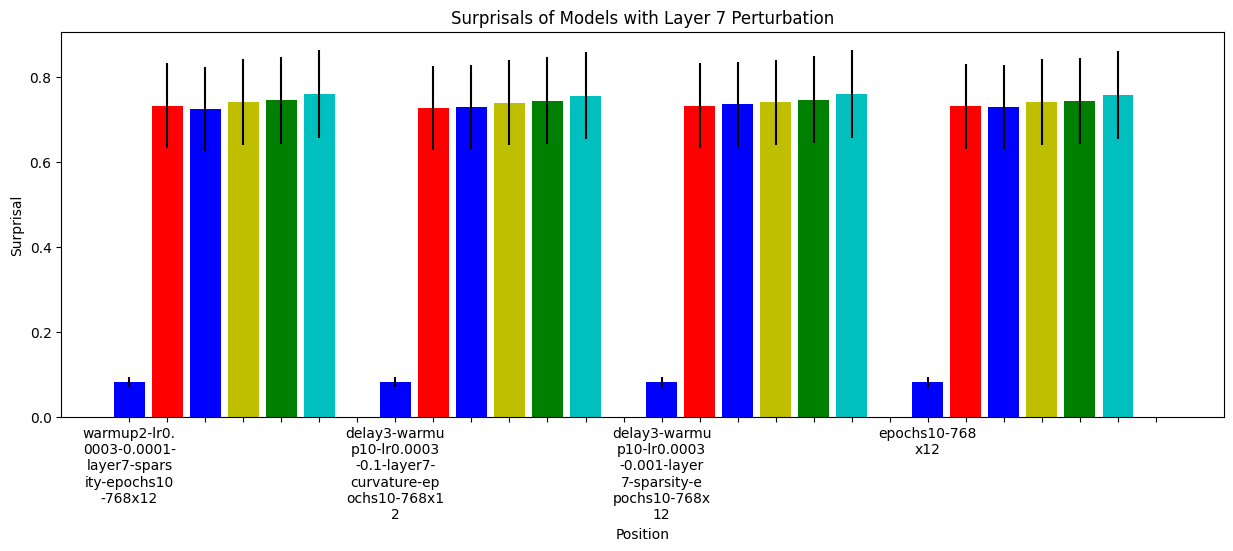

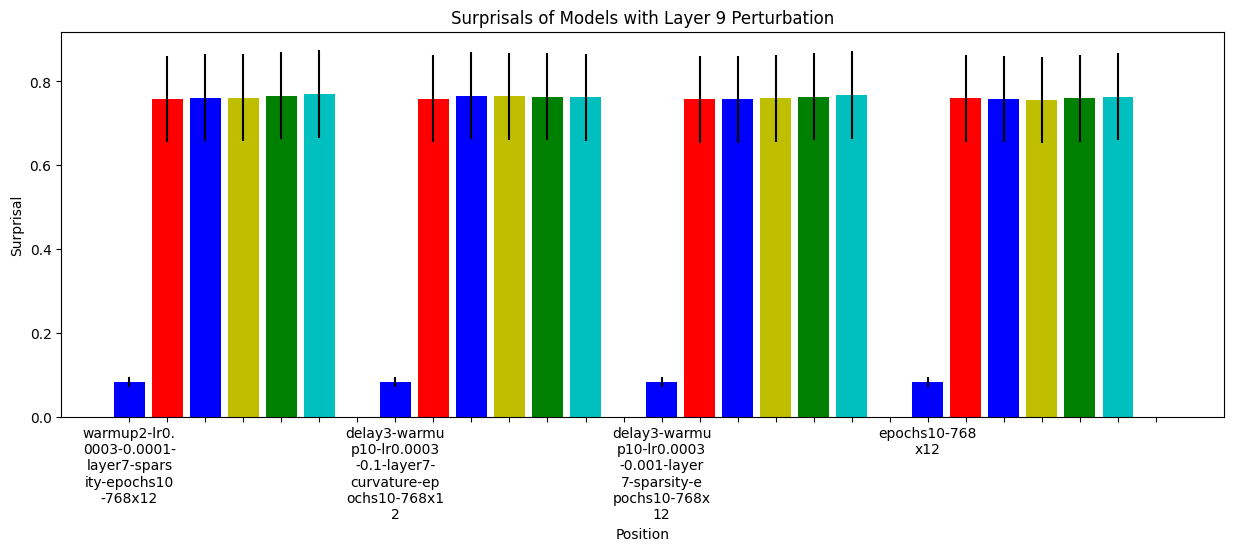

In [37]:
sizes = [0.1, 0.25, 1, 0.5, 2]

for layer in [1, 3, 5, 7, 9]:
    visualize_all_sizes_surprisal_differences(model_names, surprisal_dict, "random", layer, sizes, "word_surprisal")
# visualize_all_sizes_surprisal_differences(model_names, surprisal_dict, "random", 3, sizes, "word_surprisal")

In [ ]:
surprisal_dict[model_name][perturbation_function][layer][size][suprisal_measure]

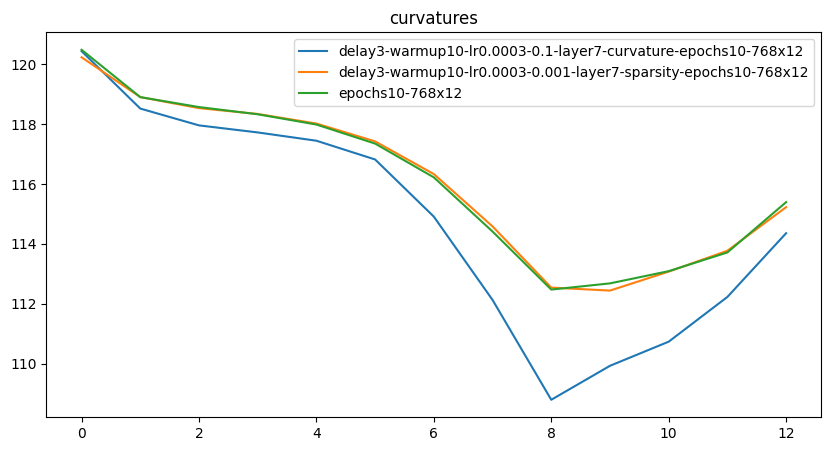

KeyError: 7

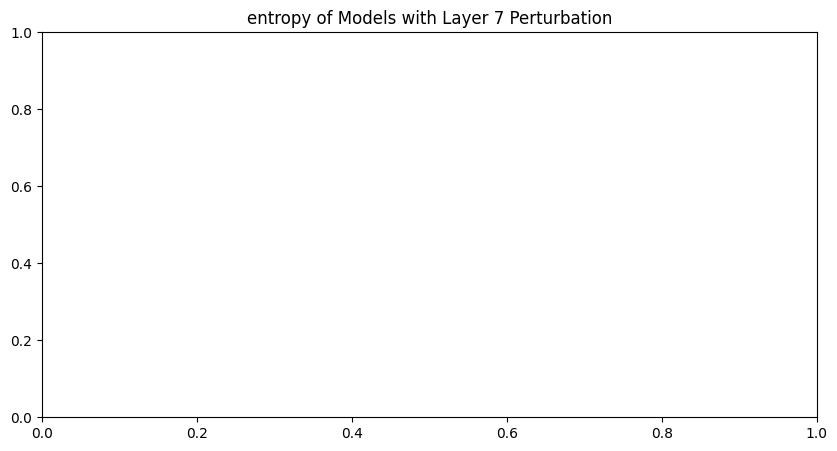